# **Active learning comparison between the two models**

## **Preliminary steps**

In [16]:
### PACKAGES

import torch

In [17]:
### FUNCTIONS AND CLASSES

from src.libs import preprocessing, visualization, utils
from src.libs.tokenizer import ReversedPairingTokenizer
from src.model.transformer import MyTransformer

In [18]:
### DEVICE

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cpu


## **Tokenizer**

In [19]:
### CREATE TOKENIZER

tokenizer = ReversedPairingTokenizer()
VOCAB_SIZE = tokenizer.ntokens
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 114


## **Data**

In [20]:
### CONSTANTS

NUM_DIGITS = 3

TRAIN_SIZE = 300
VALID_SIZE = 100
TEST_SIZE = 1000

In [21]:
### CREATE DATASETS

train_dataset = preprocessing.create_dataset(
    nb_samples=TRAIN_SIZE, num_digits=NUM_DIGITS
)

valid_dataset = preprocessing.create_dataset(
    nb_samples=VALID_SIZE, num_digits=NUM_DIGITS
)

test_dataset = preprocessing.create_dataset(nb_samples=TEST_SIZE, num_digits=NUM_DIGITS)

## **MODELS**

In [22]:
### ARCHITECTURE

NB_LAYERS = 2
NB_HEADS = 8
EMBEDDING_DIMENSION = 64
HEAD_SIZE = 8  # EMBEDDING_DIMENSION // NB_HEADS
CONTEXT_LENGTH = 20
HIDDEN_DIMENSION = 8
DROPOUT_TRANSFORMER = 0.1
DROPOUT_BAYESFORMER = 0.3

In [23]:
### TRANSFORMER

transformer = MyTransformer(
    ntoken=VOCAB_SIZE,
    d_model=EMBEDDING_DIMENSION,
    n_heads=NB_HEADS,
    dim_feedforward=HIDDEN_DIMENSION,
    nlayers=NB_LAYERS,
    dropout=DROPOUT_TRANSFORMER,
).to(DEVICE)

print(
    "number of parameters: {}".format(
        sum([x.numel() for x in transformer.parameters()])
    )
)

number of parameters: 50178


In [24]:
### BAYESFORMER

bayesformer = MyTransformer(
    ntoken=VOCAB_SIZE,
    d_model=EMBEDDING_DIMENSION,
    n_heads=NB_HEADS,
    dim_feedforward=HIDDEN_DIMENSION,
    nlayers=NB_LAYERS,
    bayes_dropout=DROPOUT_BAYESFORMER,
    bayes=True,
).to(DEVICE)

print(
    "number of parameters: {}".format(
        sum([x.numel() for x in bayesformer.parameters()])
    )
)

number of parameters: 50178


## **TRAINING**

In [25]:
### CONSTANTS

NB_EPOCHS = 100
BATCH_SIZE = 20
LEARNING_RATE = 1e-3

assert (
    TRAIN_SIZE % BATCH_SIZE == 0
    and VALID_SIZE % BATCH_SIZE == 0
    and TEST_SIZE % BATCH_SIZE == 0
), "BATCH_SIZE must be a divisor of TRAIN_SIZE, VALID_SIZE and TEST_SIZE"

In [26]:
### TRAIN TRANSFORMER

train_losses_transformer, valid_losses_transformer = utils.train(
    model=transformer,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    nb_epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    device=DEVICE,
)

EPOCH [10 / 100] ----------- TRAIN LOSS : 0.0768, VALID LOSS : 0.075569
EPOCH [20 / 100] ----------- TRAIN LOSS : 0.0566, VALID LOSS : 0.064126
EPOCH [30 / 100] ----------- TRAIN LOSS : 0.0331, VALID LOSS : 0.062407
EPOCH [40 / 100] ----------- TRAIN LOSS : 0.0223, VALID LOSS : 0.067786
EPOCH [50 / 100] ----------- TRAIN LOSS : 0.0126, VALID LOSS : 0.077342
EPOCH [60 / 100] ----------- TRAIN LOSS : 0.0104, VALID LOSS : 0.079977
EPOCH [70 / 100] ----------- TRAIN LOSS : 0.0071, VALID LOSS : 0.081346
EPOCH [80 / 100] ----------- TRAIN LOSS : 0.0058, VALID LOSS : 0.084326
EPOCH [90 / 100] ----------- TRAIN LOSS : 0.0045, VALID LOSS : 0.085673
EPOCH [100 / 100] ----------- TRAIN LOSS : 0.0048, VALID LOSS : 0.091232
Best valid loss : 0.0604


In [27]:
### TRAIN BAYESFORMER

train_losses_bayesformer, valid_losses_bayesformer = utils.train(
    model=bayesformer,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    nb_epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    vocab_size=VOCAB_SIZE,
    tokenizer=tokenizer,
    device=DEVICE,
)

EPOCH [10 / 100] ----------- TRAIN LOSS : 0.0940, VALID LOSS : 0.092601
EPOCH [20 / 100] ----------- TRAIN LOSS : 0.0776, VALID LOSS : 0.080408
EPOCH [30 / 100] ----------- TRAIN LOSS : 0.0677, VALID LOSS : 0.072822
EPOCH [40 / 100] ----------- TRAIN LOSS : 0.0588, VALID LOSS : 0.067179
EPOCH [50 / 100] ----------- TRAIN LOSS : 0.0509, VALID LOSS : 0.066269
EPOCH [60 / 100] ----------- TRAIN LOSS : 0.0467, VALID LOSS : 0.061380
EPOCH [70 / 100] ----------- TRAIN LOSS : 0.0418, VALID LOSS : 0.060476
EPOCH [80 / 100] ----------- TRAIN LOSS : 0.0372, VALID LOSS : 0.058074
EPOCH [90 / 100] ----------- TRAIN LOSS : 0.0349, VALID LOSS : 0.059081
EPOCH [100 / 100] ----------- TRAIN LOSS : 0.0337, VALID LOSS : 0.053011
Best valid loss : 0.0509


## **Plots**

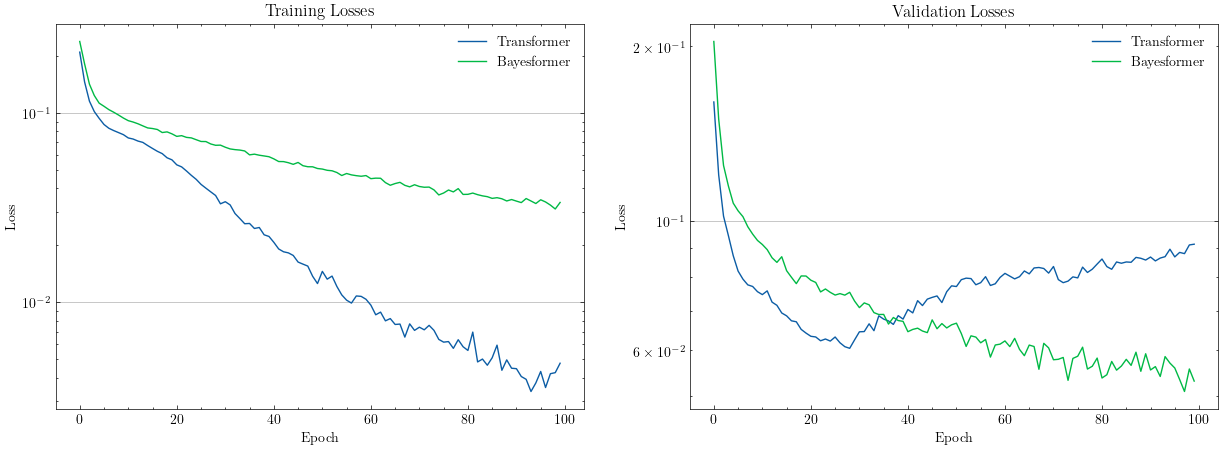

In [28]:
visualization.plot_comparison_losses(
    [train_losses_transformer, train_losses_bayesformer],
    [valid_losses_transformer, valid_losses_bayesformer],
    ["Transformer", "Bayesformer"],
    True,
)

## **Evaluation**

In [29]:
### EVALUATE TRANSFORMER

accuracy_test_transformer = utils.evaluate(
    model=transformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(f"Transformer accuracy on test set: {accuracy_test_transformer:.2f}")

### EXAMPLES

transformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = utils.generate(transformer, prompt_tensor, len(answers) + 1, DEVICE).view(
        (1, -1)
    )
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

Transformer accuracy on test set: 0.12
567+188=1675	 actual result: 755
200+532=752<EOS>	 actual result: 732
351+661=1022<EOS>	 actual result: 1012
403+509=622<EOS>	 actual result: 912
250+108=358<EOS>	 actual result: 358


In [30]:
### EVALUATE BAYESFORMER

accuracy_test_bayesformer = utils.evaluate(
    model=bayesformer,
    dataset=test_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)
print(f"Bayesformer accuracy on test set: {accuracy_test_bayesformer:.2f}")

### EXAMPLES

bayesformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = utils.generate(bayesformer, prompt_tensor, len(answers) + 1, DEVICE).view(
        (1, -1)
    )
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

Bayesformer accuracy on test set: 0.10
567+188=1645	 actual result: 755
200+532=572<EOS>	 actual result: 732
351+661=1492<EOS>	 actual result: 1012
403+509=303<EOS>	 actual result: 912
250+108=358<EOS>	 actual result: 358
